# Training the model to predict a stock price increase in the next 10 days
https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [1]:
import pandas as pd
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# Create the target variable

# pick a number of days divisble by 3 and add 10, since we will do a 66/33 test/train split
days_of_data = 310
data = yf.download(tickers='AAPL', period=f'{days_of_data}d', progress=False)

# Code the target variable 1 for a day if the price goes above
# that day's price * 1.05 (5% increase) any day in the next 10 days.
data['target'] = 0
for d in range(0, days_of_data - 10):
    close_day_zero = data.iloc[d][3]

    # look at the next 10 days
    for i in range (d+1, d+10):
        # get closing price on that day
        close_day_i = data.iloc[i][3]
        # if closing price on that day > closing price * 1.05 on initial day,
        # then set target = 1 for the initial day
        if close_day_i > close_day_zero * 1.05:
            data.iloc[d:d+1, 6] = 1
        
# truncate so we just have the first 90 rows, since we can't code the last 10
data = data.head(days_of_data - 10)

In [3]:
# check distribution of 0 vs. 1
data['target'].value_counts()

0    220
1     80
Name: target, dtype: int64

In [4]:
###############################################
# attach additional features to each row here #
###############################################

In [5]:
# 66/33 test/train split
train_days = int((days_of_data - 10) / 3 * 2)
test_days = int(train_days / 2)

x_train = data.head(train_days).drop(columns='target')
y_train = data['target'].head(train_days)

x_test = data.tail(test_days).drop(columns='target')
y_test = data['target'].tail(test_days)

In [6]:
# train the model
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.417837	valid_0's binary_logloss: 0.737627
[40]	training's binary_logloss: 0.327552	valid_0's binary_logloss: 0.772883
[60]	training's binary_logloss: 0.269087	valid_0's binary_logloss: 0.881805
[80]	training's binary_logloss: 0.227463	valid_0's binary_logloss: 0.879013
[100]	training's binary_logloss: 0.196139	valid_0's binary_logloss: 0.900691


/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [7]:
# evaluate model accuracy
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.9650
Testing accuracy 0.7400


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

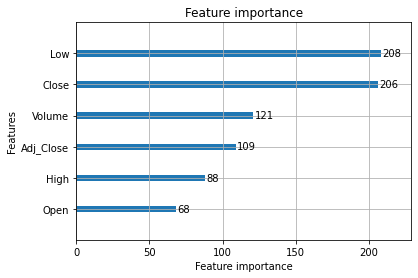

In [8]:
lgb.plot_importance(model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

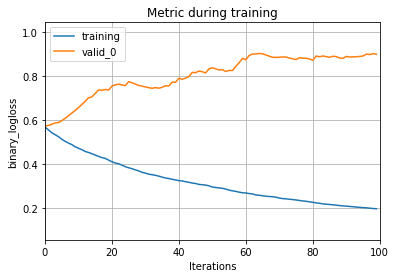

In [9]:
lgb.plot_metric(model)

/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


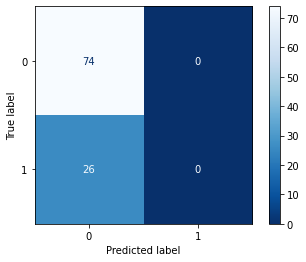

In [10]:
metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')

In [11]:
print(metrics.classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        74
           1       0.00      0.00      0.00        26

    accuracy                           0.74       100
   macro avg       0.37      0.50      0.43       100
weighted avg       0.55      0.74      0.63       100



/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi